# **Analyze downloaded data from landsat**

In [68]:
import datetime
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import joblib
from joblib import Parallel, delayed

import cv2

import warnings
warnings.simplefilter('ignore')

In [5]:
import ee
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
service_account = user_secrets.get_secret("google_service_account")
json_key_path = '/kaggle/input/gc-json-key/ticktickbloom-project-000e9745b830-json-key.json'
credentials = ee.ServiceAccountCredentials(service_account, json_key_path)

ee.Initialize(credentials)

In [6]:
metadata = pd.read_csv('/kaggle/input/ticktickbloomdataset/metadata.csv')
sub_format = pd.read_csv('/kaggle/input/ticktickbloomdataset/submission_format.csv')
train_labels = pd.read_csv('/kaggle/input/ticktickbloomdataset/train_labels.csv')

metadata = metadata.merge(train_labels, how='left', on='uid')
metadata

,uid,latitude,longitude,date,split,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,NaN,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,NaN,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,south,1.0,9682.0


In [7]:
metadata.date = pd.to_datetime(metadata.date)
metadata.sort_values(by='date', ascending=False)

,uid,latitude,longitude,date,split,region,severity,density
6540,hfvr,36.796200,-121.782000,2021-12-29,test,NaN,NaN,NaN
6864,howu,36.708500,-121.749000,2021-12-29,test,NaN,NaN,NaN
12443,nsoi,36.736800,-121.734000,2021-12-29,test,NaN,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,NaN,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5317,fwbt,44.850500,-93.515700,2013-01-04,train,midwest,1.0,476.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,midwest,1.0,558.0
13644,paev,44.822478,-93.367962,2013-01-04,train,midwest,1.0,1884.0


In [8]:
img_folder = 'landsat8_500m_v1'

img_metadata_cols = ['CLOUD_COVER', 'CLOUD_COVER_LAND', 'IMAGE_QUALITY_OLI', 'IMAGE_QUALITY_TIRS', 'DATE_ACQUIRED']

img_dir = f'/kaggle/input/pull-landsat-data-v1/{img_folder}'

In [9]:
os.listdir('/kaggle/input/pull-landsat-data-v1')

['landsat8_500m_v1',
 'errors.joblib',
 '__results__.html',
 'missed_imgs.joblib',
 'imgs_not_found_in_col.joblib',
 '__notebook__.ipynb',
 '__output__.json',
 'custom.css']

In [10]:
missed_imgs = joblib.load('/kaggle/input/pull-landsat-data-v1/missed_imgs.joblib')
imgs_not_found = joblib.load('/kaggle/input/pull-landsat-data-v1/imgs_not_found_in_col.joblib')
errors = joblib.load('/kaggle/input/pull-landsat-data-v1/errors.joblib')

In [11]:
metadata.shape[0], len(os.listdir(img_dir)), len(missed_imgs), len(imgs_not_found), len(errors)

(23570, 22766, 30, 514, 30)

In [12]:
23570 - 22766, 22766/23570*100

(804, 96.58888417479847)

In [13]:
#  what are these missing imgs? any patterns?

missing_data = metadata.loc[metadata.uid.isin(missed_imgs), :]
missing_data

# random

,uid,latitude,longitude,date,split,region,severity,density
267,ahwi,37.412500,-120.759000,2013-04-02,train,west,4.0,1.940639e+06
526,apph,35.980000,-78.795415,2018-08-16,train,south,2.0,6.099600e+04
1737,byfh,41.141242,-81.161385,2013-06-28,test,NaN,NaN,NaN
2270,cnut,39.826407,-95.528735,2013-08-26,test,NaN,NaN,NaN
3050,djlr,37.263900,-120.906000,2020-11-19,train,west,4.0,7.677500e+06
3780,edop,35.980000,-78.815797,2019-12-10,train,south,1.0,2.905000e+03
4085,emss,39.826407,-95.528735,2019-09-16,test,NaN,NaN,NaN
4098,encv,41.182770,-80.759996,2018-12-06,test,NaN,NaN,NaN
4144,eoum,38.115600,-121.494000,2013-05-21,train,west,4.0,3.936874e+06
5001,fnaw,35.980000,-78.795663,2018-08-16,train,south,3.0,1.745960e+05


In [14]:
missing_data.split.value_counts(normalize=False)

train    22
test      8
Name: split, dtype: int64

In [15]:
all_missing_imgs = missed_imgs + imgs_not_found + list(metadata[metadata.date < '2013-04-01'].uid.values)
len(all_missing_imgs) #

804

In [16]:
all_missing_data = metadata[metadata.uid.isin(all_missing_imgs)]
all_missing_data

,uid,latitude,longitude,date,split,region,severity,density
20,aaoy,35.790000,-79.026392,2018-06-13,train,south,1.0,3485.0
30,aauy,36.313000,-79.114978,2020-02-26,test,NaN,NaN,NaN
42,abcx,38.050500,-121.418000,2013-01-15,train,west,3.0,778068.5
73,abzb,36.313000,-79.114829,2020-02-26,test,NaN,NaN,NaN
87,aclb,38.483122,-75.129692,2020-11-10,train,south,1.0,10000.0
...,...,...,...,...,...,...,...,...
23247,zqnd,40.115030,-79.532030,2020-09-28,test,NaN,NaN,NaN
23361,ztrj,35.678669,-79.214340,2018-06-13,train,south,1.0,2905.0
23386,zuob,35.910177,-79.159309,2013-02-12,train,south,1.0,6256.0
23391,zurh,35.671802,-79.227094,2015-01-27,train,south,1.0,508.0


In [17]:
all_missing_data.split.value_counts()

train    623
test     181
Name: split, dtype: int64

In [18]:
print(metadata.region.value_counts(normalize=True))
print(all_missing_data.region.value_counts(normalize=True))
all_missing_data.region.value_counts(normalize=True)

south        0.583118
west         0.220926
midwest      0.128957
northeast    0.066999
Name: region, dtype: float64
south        0.635634
west         0.187801
midwest      0.117175
northeast    0.059390
Name: region, dtype: float64


south        0.635634
west         0.187801
midwest      0.117175
northeast    0.059390
Name: region, dtype: float64

<AxesSubplot:ylabel='Density'>

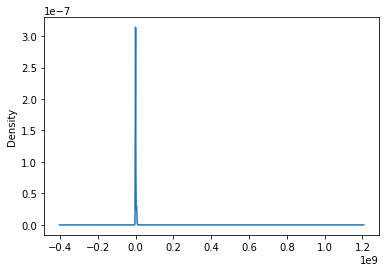

In [19]:
#  dist of density
train_labels.density.plot.kde()

In [20]:
cur_data = metadata[~metadata.uid.isin(all_missing_imgs)]
cur_data                                  # avaliable imgs data

,uid,latitude,longitude,date,split,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,NaN,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,NaN,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,south,1.0,9682.0


# How are the imgs?

In [21]:
img_paths = os.listdir(img_dir)

In [22]:
def get_img_and_metadata(img_arr: np.ndarray)->(np.ndarray, np.ndarray):
    """returns img_band_arrays and metadata from given array"""
    return img_arr[:11], img_arr[11:]

In [24]:
rand_n = np.random.randint(0, len(img_paths))
rand_img_name = img_paths[rand_n]
print(img_paths[rand_n])

display(metadata[metadata.uid == rand_img_name.split('.')[0]])

rand_img_path = os.path.join(img_dir, rand_img_name)
rand_img = joblib.load(rand_img_path)

img_arr, img_metadata = get_img_and_metadata(rand_img)

img_metadata

# find better value to normalize images!

vpuz.npy


,uid,latitude,longitude,date,split,region,severity,density
19618,vpuz,35.61,-78.954246,2018-07-16,train,south,3.0,420746.0


array([16.35, 16.35, 9, 9, '2018-07-15'], dtype=object)

In [25]:
img_arr, img_metadata = get_img_and_metadata(joblib.load(os.path.join(img_dir, rand_img_name)))
# img_arr
img_metadata

array([16.35, 16.35, 9, 9, '2018-07-15'], dtype=object)

In [26]:
bands = ['B1', 'B2', 'B3', 'B4' ,'B5','B6','B7','B8','B9','B10','B11']

In [27]:
img_arr[0].max()

38720

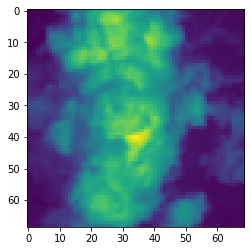

In [28]:
pan_img = img_arr[7]
plt.imshow(pan_img)

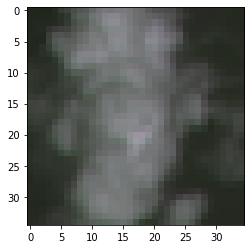

In [62]:
# Panchromatic sharpening 

# get bgr img
r, g, b = rand_img[3], rand_img[1], rand_img[2] 
bgr_img = np.dstack((b, g, r))/65_535
plt.imshow(bgr_img)

# convert rgb to hsv!
hsv_img = cv2.cvtColor(bgr_img.astype('float32'), cv2.COLOR_BGR2HSV)
# plt.imshow(hsv_img)

In [63]:
pan_img.shape

(69, 69)

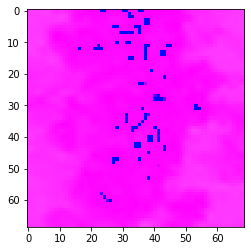

In [64]:
# upscale 'h' and 's' in hsv_img to pan_img size
upscaled_hsv_img = cv2.resize(hsv_img, pan_img.shape, interpolation=cv2.INTER_CUBIC)
upscaled_hsv_img.shape

# swap 'v' in hsv with panchrome band
upscaled_hsv_img.transpose([2, 1, 0])[2] = pan_img
plt.imshow(upscaled_hsv_img) # wtf  is happening here!!

In [65]:
upscaled_hsv_img

array([[[1.4410526e+02, 2.3174934e-01, 8.1150000e+03],
        [1.4382683e+02, 2.2976843e-01, 8.2090000e+03],
        [1.4337456e+02, 2.2655085e-01, 8.2820000e+03],
        ...,
        [1.5013593e+02, 2.2367701e-01, 9.2270000e+03],
        [1.5046765e+02, 2.2441033e-01, 9.4570000e+03],
        [1.5066714e+02, 2.2489600e-01, 9.5250000e+03]],

       [[1.4433226e+02, 2.3279621e-01, 8.2070000e+03],
        [1.4410994e+02, 2.2993837e-01, 8.2430000e+03],
        [1.4374872e+02, 2.2531189e-01, 8.2880000e+03],
        ...,
        [1.5018599e+02, 2.2464882e-01, 9.1190000e+03],
        [1.5044760e+02, 2.2553237e-01, 9.4280000e+03],
        [1.5060472e+02, 2.2610562e-01, 9.4760000e+03]],

       [[1.4470352e+02, 2.3450521e-01, 8.3210000e+03],
        [1.4457088e+02, 2.3022076e-01, 8.2680000e+03],
        [1.4435513e+02, 2.2330202e-01, 8.4160000e+03],
        ...,
        [1.5026755e+02, 2.2622354e-01, 8.9930000e+03],
        [1.5041814e+02, 2.2734514e-01, 9.3710000e+03],
        [1.5050818e+02

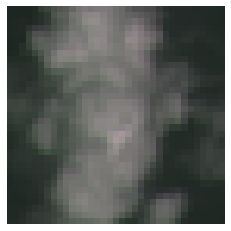

In [67]:
r, g, b = rand_img[3], rand_img[1], rand_img[2] 
rgb = np.dstack((r, g, b))/65_535
plt.imshow(rgb)
plt.axis('off');

In [49]:
rgb.shape

(35, 35, 3)

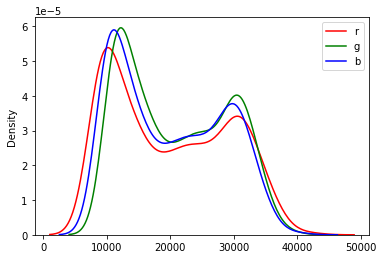

In [77]:
#  what are the distribution of pixel values (DNs)

sns.kdeplot(r.ravel(), c='r', label='r')
sns.kdeplot(g.ravel(), c='g', label='g')
sns.kdeplot(b.ravel(), c='b', label='b')
plt.legend()
# r

In [ ]:
# Bands	Wavelength
# (micrometers)	Resolution
# (meters)
# Band 1 - Coastal aerosol	0.43-0.45	30
# Band 2 - Blue	0.45-0.51	30
# Band 3 - Green	0.53-0.59	30
# Band 4 - Red	0.64-0.67	30
# Band 5 - Near Infrared (NIR)	0.85-0.88	30
# Band 6 - SWIR 1	1.57-1.65	30
# Band 7 - SWIR 2	2.11-2.29	30
# Band 8 - Panchromatic	0.50-0.68	15
# Band 9 - Cirrus	1.36-1.38	30
# Band 10 - Thermal Infrared (TIRS) 1	10.6-11.19	100
# Band 11 - Thermal Infrared (TIRS) 2	11.50-12.51	100

In [ ]:
# LANDSAT/LC08/C02/T1_L2

# **So...** 

- total of 804 imgs missing (623/181)
- some are before april 1st of 2013 and 30 due to "clipping" error and some are not found! <-- Investigate not found images!
- **Just reailized that i have downloaded raw values instead of surface reflectance values.!!**
- 

# **ToDos:**

- How to best normalize data?
- Figure out best bands for detecting chlorophyll in water
- **Holy heck download sr images instead of raw ones!**
